## Using Pytorch for Kaggle's Dog vs Cat Classifier

![Cat vs Dog](./static/cat_dog.jpeg)

* Organizing Train/Validation data  [Refer preprocess.py](preprocess.py)
* Transfer Learning
* Training and save the model
* Inference using test data

### Importing Essential Libraries

In [1]:
import numpy as np
import torch
from torch import nn,optim
import torch.nn.functional as F
from torchvision import transforms,datasets,models
from collections import OrderedDict
import matplotlib.pyplot as plt
from PIL import Image
import time

### Helper Function for Plotting image and it's class

In [2]:
def imshow(image,classes=None,normalized=False):
    image = image.numpy().transpose((1,2,0))
    
    if normalized:
        mean = np.array([0.485,0.456,0.406])
        std = np.array([0.229,0.224,0.225])
        image = std * image + mean
        image = np.clip(image,0,1)
        
    plt.imshow(image)
    
    if classes is not None:
        if int(classes) == 1:
            plt.title('Class: dog')
        else:
            plt.title('Class: cat')

### Device agnostic code to check for cuda availablity

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Importing Data and Data Augmentation

In [4]:
train_dir = 'data/train/'
val_dir = 'data/val/'

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(255),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                        std=[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                        std=[0.229,0.224,0.225])
])

train_data = datasets.ImageFolder(train_dir,transform=train_transform)
trainloader = torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True,num_workers=4)

val_data = datasets.ImageFolder(val_dir,transform=val_transform)
valloader = torch.utils.data.DataLoader(val_data,batch_size=64,shuffle=True,num_workers=4)

print("classes in dataset: " + str(val_data.classes))

classes in dataset: ['cat', 'dog']


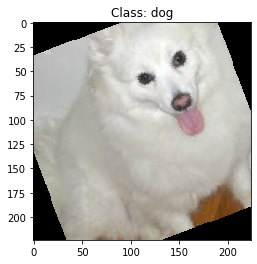

In [5]:
train_img,train_label = next(iter(trainloader))
imshow(train_img[0],train_label[0],normalized=True)

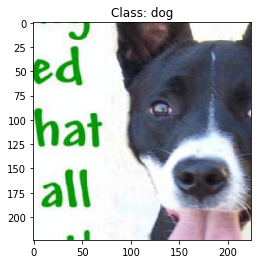

In [6]:
test_img,test_label = next(iter(valloader))
imshow(test_img[0],test_label[0],normalized=True)

### Transfer Learning

In [7]:
model = models.densenet121(pretrained=True)
model.classifier

Linear(in_features=1024, out_features=1000, bias=True)

In [8]:
## freezing convolution parameters ##
for param in model.parameters():
    param.requires_grad = False

### Defining final output layers

In [10]:
classifier = nn.Sequential(OrderedDict([
    ('hidden_1',nn.Linear(1024,512)),
    ('relu_1',nn.ReLU()),
    ('dropout',nn.Dropout(p=0.5)),
    ('hidden_2',nn.Linear(512,2)),
    ('log_softmax',nn.LogSoftmax(dim=1))
]))


# class Net(nn.Module):
#     def __init__(self,inp_nodes,out_nodes,hidden_nodes):
#         super().__init__()
#         self.hidden_1 = nn.Linear(inp_nodes,hidden_nodes[0])
#         self.hidden_2 = nn.Linear(hidden_nodes[0],out_nodes)
#         self.dropout = nn.Dropout(p=0.5)
#     def forward(self,x):
#         x = F.relu(self.hidden_1(x))
#         x = self.dropout(x)
#         x = F.log_softmax(self.hidden_2(x),dim=1)
#         return x
    
model.classifier = classifier #Net(1024,2,[512])
model = model.to(device)
model.classifier

Sequential(
  (hidden_1): Linear(in_features=1024, out_features=512, bias=True)
  (relu_1): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (hidden_2): Linear(in_features=512, out_features=2, bias=True)
  (log_softmax): LogSoftmax()
)

### Training the Model

In [11]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(),lr=0.01)

In [12]:
epochs = 1
iterations = 0
print_every = 1

train_losses,test_losses = [],[]

for epoch in range(epochs):
    start = time.time()
    running_loss = 0
    for image,label in trainloader:
        iterations += 1
        image,label = image.to(device),label.to(device)
        optimizer.zero_grad()
        logps = model.forward(image)
        loss = criterion(logps,label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    if epoch % print_every == 0:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            for image,label in valloader:
                
                image,label = image.to(device),label.to(device)
                logps = model.forward(image)
                batch_loss = criterion(logps,label)
                test_loss += batch_loss.item()
                
                ps = torch.exp(logps)
                top_p,top_class = ps.topk(1,dim=1)
                equals = top_class == label.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
        test_losses.append(test_loss/len(valloader))
        train_losses.append(running_loss/len(trainloader))
        
        print(f"Epoch:{epoch+1}/{epochs}..Train loss:{running_loss/len(trainloader):.3f}.."
             f"Test loss:{test_loss/len(valloader):.3f} Test accuracy:{accuracy/len(valloader):.3f}..."
             f"time:{time.time() - start}")
        running_loss = 0
        model.eval()
torch.save(model,'checkpoint1.pth')

Epoch:1/1..Train loss:2.189..Test loss:0.174 Test accuracy:0.930...time:499.291983127594


In [14]:
model  = torch.load('checkpoint1.pth')

### Inference from test data

In [44]:
def predict(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    img_tensor = val_transform(img)
    img_tensor = torch.stack([img_tensor])
    softmax = nn.Softmax(dim=1)
    pred = softmax(model(img_tensor))
    if pred[0,0].item() > pred[0,1].item():
        plt.title('Class: Cat')
    else:
        plt.title('Class: Dog')

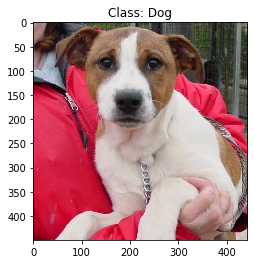

In [51]:
predict('./data/test/21.jpg')

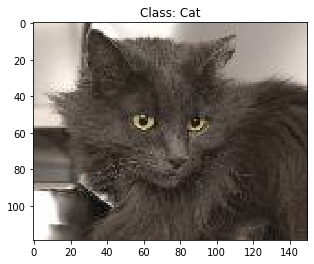

In [52]:
predict('./data/test/38.jpg')

### Important Note
> This model was trained using only 1000 images.

> 500 cat and 500 dog images for training.

> another 250 cat and 250 dog images for validation.

> Trained on intel core i5-4460 w/o cuda.

> Training time for 1 epoch: 483.96 sec {8:30 min:sec}.

> Testing acc: 94% after 1 epoch
